# Training ML models to predict CFD 


In [1]:
import os, glob, re, time, random
import copy as cp
import numpy as np
import statistics, scipy
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as PathEffects
matplotlib.rcParams['figure.dpi']= 200
matplotlib.rcParams.update({'font.size': 5})

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import joblib

In [3]:
from __future__ import print_function

## <span style='background :yellow' > Import Shape Modelling PCA Data </span> 

In [4]:
ssm_pca_path = "/home/endrit/Documents/Modelling/COA/pipeline_1650/pca_u_new_shapes.csv"

In [5]:
ssm_file = open(ssm_pca_path, "r")
ssm_df = pd.read_csv(ssm_file, header=None, index_col=False)
ssm_pca_u = ssm_df.to_numpy()
print(np.shape(ssm_pca_u))

(1650, 66)


**keep only first 20 modes (99% cumvar)**

In [6]:
ssm_pca_u = ssm_pca_u[:, :20]
print(np.shape(ssm_pca_u))

(1650, 20)


**delete self-intersecting subjects**

In [7]:
ids_to_delete = [905, 1232, 1418, 1525]

ssm_pca_u = np.delete(ssm_pca_u, ids_to_delete, 0)
print(np.shape(ssm_pca_u))

(1646, 20)


## <span style='background :yellow' > Import CFD Data </span> 

In [8]:
###################################################################
# sorting function (human sorting for Shooting_0_, Shooting_1 etc.)
###################################################################
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    l.sort(key=alphanum_key)
    return l

In [9]:
cfd_path = "/home/endrit/Documents/Modelling/COA/pipeline_1650/Results_CFD/Point_Cloud_Interpolated/"

**import all filenames**

In [10]:
fnames = sort_nicely(os.listdir(cfd_path))

**import all csv flow fields (keep columns 1: pressure, 3: velocity)**

In [11]:
# build array of csv files
cfd_files = sort_nicely(os.listdir(cfd_path))
cfd_data = []
cfd_empty = [] # only x,y,z

for fn in cfd_files:
    file = open(cfd_path + fn, "r")
    df = pd.read_csv(file, index_col=False)
    df.columns = df.columns.str.replace(' ', '')
    # build list of cfd or empty dataframes
    df_cfd = df.drop(df.columns[[0, 2, 4, 5, 6, 7]], axis=1)
    df_empty = df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1)
    cfd_data.append(df_cfd.values)
    cfd_empty.append(df_empty.values)

In [12]:
# cfd_data[subject][node][pressure/velocity]
cfd_data = np.array(cfd_data)

# p_data[subject][node_pressure]
p_data = np.squeeze(cfd_data[:, :, :1])
v_data = np.squeeze(cfd_data[:, :, 1:])

In [13]:
# 1646 subjects, 27420 pressure nodes (features)
np.shape(p_data)

(1646, 27420)

### <span style='background :yellow' > SPLIT DATASET </span> 

In [14]:
train_n = 1546

In [15]:
p_data_train, p_data_test = p_data[:train_n], p_data[train_n:]
v_data_train, v_data_test = v_data[:train_n], v_data[train_n:]

In [16]:
X_train, X_test = ssm_pca_u[:train_n], ssm_pca_u[train_n:]

# <span style='background :cyan' > DNN PREDICTION </span> 

**Import models**

In [17]:
run_attempt = 3

model_dir = os.getcwd() + "/Results_ML/Run_" + str(run_attempt) + "/model/"

# load S and Vt matrices (needed for estimators)
S_p_tensor = tf.convert_to_tensor(np.load(model_dir + 'S_p.npy'))
S_v_tensor = tf.convert_to_tensor(np.load(model_dir + 'S_v.npy'))
Vt_p_tensor = tf.convert_to_tensor(np.load(model_dir + 'Vt_p.npy'))
Vt_v_tensor = tf.convert_to_tensor(np.load(model_dir + 'Vt_v.npy'))

# load pipeline
pipeline_loaded = joblib.load(model_dir + 'pipeline.pkl')
scaler_p = pipeline_loaded[0]
scaler_v = pipeline_loaded[1]

# load estimators
dnn_p = keras.models.load_model(model_dir + "dnn_p.h5")
dnn_v = keras.models.load_model(model_dir + "dnn_v.h5")

In [18]:
# output save directory

data_dir = model_dir.replace("model/", "predictions/")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

print(data_dir)

/home/endrit/Documents/Modelling/COA/pipeline_1650/Results_ML/Run_3/predictions/


**Pressure**  

In [19]:
time_1 = time.time()

# predict standardised data
P_pred = dnn_p.predict(X_test)
# reverse standardisation
P_pred_inv_scaling = scaler_p.inverse_transform(P_pred)

time_2 = time.time()
print('{} seconds'.format(time_2 - time_1))

1.4712631702423096 seconds


In [20]:
np.shape(P_pred)

(100, 27420)

**Velocity**

In [21]:
time_1 = time.time()

# predict standardised data
V_pred = dnn_v.predict(X_test)

# inverse standardisation 
V_pred_inv_scaling = scaler_v.inverse_transform(V_pred)
# make all negatives = 0
V_pred_inv_scaling_no_negatives = np.clip(V_pred_inv_scaling, a_min=0, a_max=None)

time_2 = time.time()
print('{} seconds'.format(time_2 - time_1))

1.0337023735046387 seconds


In [22]:
np.shape(V_pred_inv_scaling)

(100, 27420)

**Build new files**

In [23]:
pred_empty_csv = cfd_empty[train_n:]

In [24]:
# add predictions to csv
pred_csv = np.dstack((pred_empty_csv, P_pred_inv_scaling))
pred_csv = np.dstack((pred_csv, V_pred_inv_scaling_no_negatives))

# calculate P and V errors and add them to csv
errors_p, errors_v = [], []
for i in range(len(pred_csv)):
    err_p = abs(np.subtract(pred_csv[i, :, 3], p_data[i+len(X_train), :]))
    err_v = abs(np.subtract(pred_csv[i, :, 4], v_data[i+len(X_train), :]))
    errors_p.append(err_p)
    errors_v.append(err_v)
    
pred_csv = np.dstack((pred_csv, errors_p))
pred_csv = np.dstack((pred_csv, errors_v))

In [25]:
np.shape(pred_csv)

(100, 27420, 7)

### Inspecting errors

In [26]:
test_filenames = fnames[train_n:]
test_filenames = [s.replace("_ext.csv", "") for s in test_filenames]

**get matrix of errors (100 rows, 4 columns)**

In [27]:
pressure_pred_evaluation = pd.DataFrame(columns=['filename', 'range_true (Pa)', 'MAE (Pa)', 'NMAE (%)'])
for i in range(p_data_test.shape[0]):
    MAE = mean_absolute_error(p_data_test[i], P_pred_inv_scaling[i])
    p_range = max(p_data_test[i]) - min(p_data_test[i])
    pressure_pred_evaluation.loc[i] = [test_filenames[i], p_range, MAE, MAE*100/p_range]
    
velocity_pred_evaluation = pd.DataFrame(columns=['filename', 'range_true (m/s)', 'MAE (m/s)', 'NMAE (%)'])
for i in range(v_data_test.shape[0]):
    MAE = mean_absolute_error(v_data_test[i], V_pred_inv_scaling_no_negatives[i])
    v_range = max(v_data_test[i]) - min(v_data_test[i])
    velocity_pred_evaluation.loc[i] = [test_filenames[i], v_range, MAE, MAE*100/v_range]

**get normalised error for each subject and node (100 rows, 27420 columns)**

In [28]:
p_abs_difference_points = []
for i in range(p_data_test.shape[0]):
    abs_diff = abs(p_data_test[i] - P_pred_inv_scaling[i])
    p_range = max(p_data_test[i]) - min(p_data_test[i])
    p_abs_difference_points.append(abs_diff*100/p_range)
    
v_abs_difference_points = []
for i in range(v_data_test.shape[0]):
    abs_diff = abs(v_data_test[i] - V_pred_inv_scaling[i])
    v_range = max(v_data_test[i]) - min(v_data_test[i])
    v_abs_difference_points.append(abs_diff*100/v_range)

In [29]:
average_p_abs_difference_points = np.mean(p_abs_difference_points, axis=0)
average_v_abs_difference_points = np.mean(v_abs_difference_points, axis=0)
print(np.mean(average_p_abs_difference_points))
print(np.mean(average_v_abs_difference_points))

4.327872283835368
5.1810254505262225


In [30]:
#np.savetxt(data_dir + "/" +"mean_pressure_%_error_per_point.csv", average_p_abs_difference_points, delimiter=",")
#np.savetxt(data_dir + "/" +"mean_velocity_%_error_per_point.csv", average_v_abs_difference_points, delimiter=",")

**MAE**

In [31]:
print("average MAE = " + "{:.2f}".format(np.mean(pressure_pred_evaluation['MAE (Pa)'])) + " Pa")
print("StDev = " + "{:.2f}".format(statistics.stdev(pressure_pred_evaluation['MAE (Pa)'])) + " Pa")
print("")
print("average MAE = " + "{:.2f}".format(np.mean(velocity_pred_evaluation['MAE (m/s)'])) + " m/s")
print("StDev = " + "{:.2f}".format(statistics.stdev(velocity_pred_evaluation['MAE (m/s)'])) + " m/s")

average MAE = 639.07 Pa
StDev = 512.09 Pa

average MAE = 0.23 m/s
StDev = 0.07 m/s


In [32]:
print("value of max MAE = " + "{:.2f}".format(max(pressure_pred_evaluation['MAE (Pa)'])) + " Pa")
print("index of max MAE = " + str(np.argmax(pressure_pred_evaluation['MAE (Pa)'])))
print("value of min MAE = " + "{:.2f}".format(min(pressure_pred_evaluation['MAE (Pa)'])) + " Pa")
print("index of min MAE = " + str(np.argmin(pressure_pred_evaluation['MAE (Pa)'])))
print("")
print("value of max MAE = " + "{:.2f}".format(max(velocity_pred_evaluation['MAE (m/s)'])) + " m/s")
print("index of max MAE = " + str(np.argmax(velocity_pred_evaluation['MAE (m/s)'])))
print("value of min MAE = " + "{:.2f}".format(min(velocity_pred_evaluation['MAE (m/s)'])) + " m/s")
print("index of min MAE = " + str(np.argmin(velocity_pred_evaluation['MAE (m/s)'])))

value of max MAE = 3439.14 Pa
index of max MAE = 35
value of min MAE = 205.11 Pa
index of min MAE = 49

value of max MAE = 0.48 m/s
index of max MAE = 21
value of min MAE = 0.12 m/s
index of min MAE = 31


**NMAE**

In [33]:
print("average NMAE = " + "{:.2f}".format(np.mean(pressure_pred_evaluation['NMAE (%)'])) + " %")
print("StDev = " + "{:.2f}".format(statistics.stdev(pressure_pred_evaluation['NMAE (%)'])) + " %")
print("")
print("average NMAE = " + "{:.2f}".format(np.mean(velocity_pred_evaluation['NMAE (%)'])) + " %")
print("StDev = " + "{:.2f}".format(statistics.stdev(velocity_pred_evaluation['NMAE (%)'])) + " %")

average NMAE = 4.33 %
StDev = 1.68 %

average NMAE = 5.18 %
StDev = 1.20 %


In [34]:
print("value of max NMAE = " + "{:.2f}".format(max(pressure_pred_evaluation['NMAE (%)'])) + " %")
print("index of max NMAE = " + str(np.argmax(pressure_pred_evaluation['NMAE (%)'])))
print("value of min NMAE = " + "{:.2f}".format(min(pressure_pred_evaluation['NMAE (%)'])) + " %")
print("index of min NMAE = " + str(np.argmin(pressure_pred_evaluation['NMAE (%)'])))
print("")
print("value of max NMAE = " + "{:.2f}".format(max(velocity_pred_evaluation['NMAE (%)'])) + " %")
print("index of max NMAE = " + str(np.argmax(velocity_pred_evaluation['NMAE (%)'])))
print("value of min NMAE = " + "{:.2f}".format(min(velocity_pred_evaluation['NMAE (%)'])) + " %")
print("index of min NMAE = " + str(np.argmin(velocity_pred_evaluation['NMAE (%)'])))

value of max NMAE = 9.47 %
index of max NMAE = 53
value of min NMAE = 1.64 %
index of min NMAE = 23

value of max NMAE = 9.94 %
index of max NMAE = 22
value of min NMAE = 3.15 %
index of min NMAE = 9


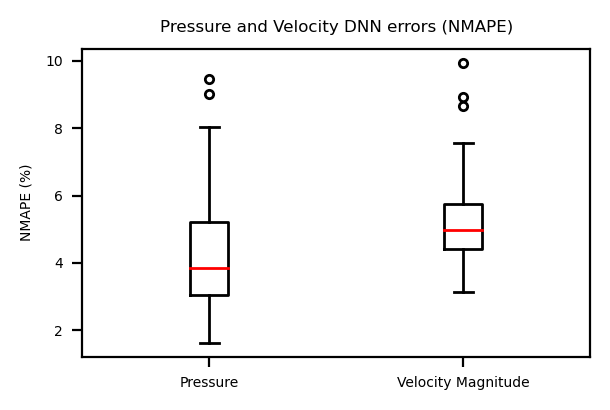

In [35]:
# BOX PLOT - AVERAGE errors per subject, then do box plot

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.boxplot([pressure_pred_evaluation['NMAE (%)'], 
               velocity_pred_evaluation['NMAE (%)']], 
               labels=["Pressure", "Velocity Magnitude"],
               flierprops=dict(marker='.'),
               medianprops=dict(color='r'))
ax.set(title="Pressure and Velocity DNN errors (NMAPE)", ylabel = "NMAPE (%)")

fig.tight_layout()
plt.show()
#plt.savefig("/home/endrit/Documents/Deliverables/Papers/ML_COA/Figures/errors_boxplot.svg")

NameError: name 'ranges_p' is not defined

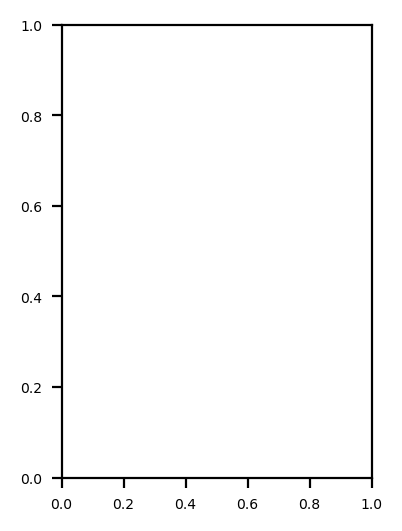

In [36]:
# box plot - AVERAGE errors PER NODE then do boxplot

fig, ax = plt.subplots(1, 1, figsize=(2, 3))

p_data_flatten_errors = abs(p_data_test.flatten() - P_pred_inv_scaling.flatten())
v_data_flatten_errors = abs(v_data_test.flatten() - V_pred_inv_scaling.flatten())

p_data_flatten_errors = p_data_flatten_errors * 100 / np.repeat(ranges_p, p_data_test[0].shape[0])
v_data_flatten_errors = v_data_flatten_errors * 100 / np.repeat(ranges_v, v_data_test[0].shape[0])

p_data_flatten_errors = p_data_flatten_errors.reshape((p_data_test.shape[0], p_data_test.shape[1]))
v_data_flatten_errors = v_data_flatten_errors.reshape((v_data_test.shape[0], v_data_test.shape[1]))

p_data_flatten_errors = np.mean(p_data_flatten_errors, axis=0)
v_data_flatten_errors = np.mean(v_data_flatten_errors, axis=0)


ax.boxplot([p_data_flatten_errors, 
               v_data_flatten_errors], 
               labels=["Pressure", "Velocity Magnitude"],
               showfliers=False,
               widths=0.3,
               flierprops=dict(marker='.'),
               medianprops=dict(color='r'))
ax.set(title="Pressure and Velocity DNN errors (NMAE)", ylabel = "NMAE (%)")

print(np.median(p_data_flatten_errors))
print(np.median(v_data_flatten_errors))
print(np.percentile(p_data_flatten_errors, [25, 75])[1] - np.percentile(p_data_flatten_errors, [25, 75])[0])
print(np.percentile(v_data_flatten_errors, [25, 75])[1] - np.percentile(v_data_flatten_errors, [25, 75])[0])

fig.tight_layout()
#plt.savefig("/home/endrit/Documents/Deliverables/Papers/ML_COA/Figures/errors_boxplot_average_nodes.svg")
plt.show()

In [ ]:
# box plot - NO averaging, concat all subjects then do pred vs true errors and plot

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

p_data_flatten_errors = abs(p_data_test.flatten() - P_pred_inv_scaling.flatten())
v_data_flatten_errors = abs(v_data_test.flatten() - V_pred_inv_scaling.flatten())

p_data_flatten_errors = p_data_flatten_errors * 100 / np.repeat(ranges_p, p_data_test[0].shape[0])
v_data_flatten_errors = v_data_flatten_errors * 100 / np.repeat(ranges_v, v_data_test[0].shape[0])

print(np.mean(p_data_flatten_errors))
print(np.mean(v_data_flatten_errors))

ax.boxplot([p_data_flatten_errors, 
               v_data_flatten_errors], 
               labels=["Pressure", "Velocity Magnitude"],
               showfliers=False,
               flierprops=dict(marker='.'),
               medianprops=dict(color='r'))
ax.set(title="Pressure and Velocity DNN errors (NMAE)", ylabel = "NMAE (%)")

fig.tight_layout()
#plt.savefig("/home/endrit/Documents/Deliverables/Papers/ML_COA/Figures/errors_boxplot_all_nodes.svg")
plt.show()

### Shape mode vs NMAE

In [37]:
R_0vsP = scipy.stats.pearsonr(X_test[:, 0], pressure_pred_evaluation['NMAE (%)'])
R_1vsP = scipy.stats.pearsonr(X_test[:, 1], pressure_pred_evaluation['NMAE (%)'])
R_2vsP = scipy.stats.pearsonr(X_test[:, 2], pressure_pred_evaluation['NMAE (%)'])
R_0vsV = scipy.stats.pearsonr(X_test[:, 0], velocity_pred_evaluation['NMAE (%)'])
R_1vsV = scipy.stats.pearsonr(X_test[:, 1], velocity_pred_evaluation['NMAE (%)'])
R_2vsV = scipy.stats.pearsonr(X_test[:, 2], velocity_pred_evaluation['NMAE (%)'])

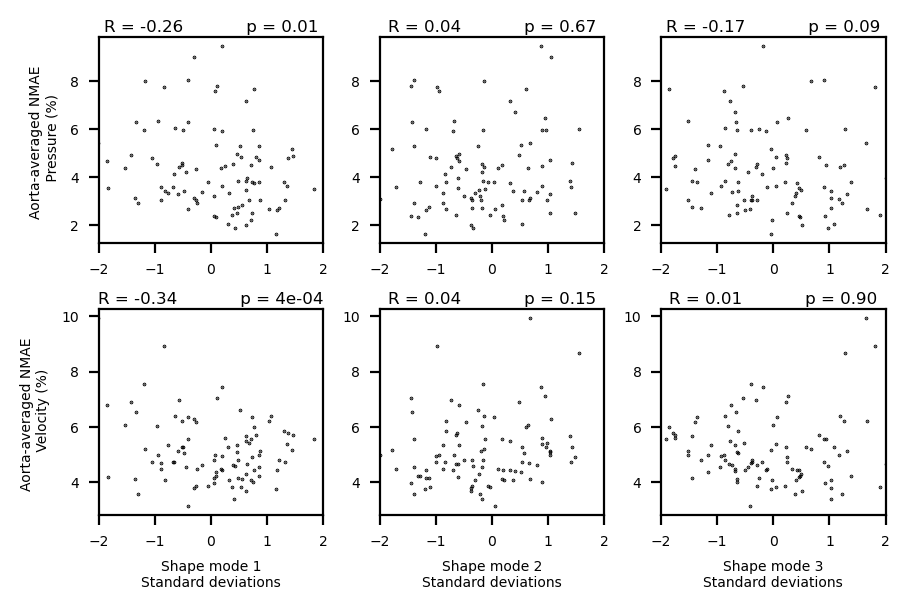

In [70]:
fig, ax = plt.subplots(2, 3, figsize=(4.5, 3))

ax[0][0].scatter(X_test[:, 0]*8, pressure_pred_evaluation['NMAE (%)'], s=0.1, c="k", marker="o")
ax[0][0].set_ylabel("Aorta-averaged NMAE \n Pressure (%)")
ax[0][0].set_title("R = "+"{:.2f}".format(R_0vsP[0])+"            p = "+"{:.2f}".format(R_0vsP[1]), fontsize=6, pad=0.2, y=1.02)
ax[0][0].set_xlim(left=-2, right=2)

ax[0][1].scatter(X_test[:, 1]*8, pressure_pred_evaluation['NMAE (%)'], s=0.1, c="k")
ax[0][1].set_title("R = "+"{:.2f}".format(R_1vsP[0])+"            p = "+"{:.2f}".format(R_1vsP[1]), fontsize=6, pad=0.2, y=1.02)
ax[0][1].set_xlim(left=-2, right=2)

ax[0][2].scatter(X_test[:, 2]*8, pressure_pred_evaluation['NMAE (%)'], s=0.1, c="k")
ax[0][2].set_title("R = "+"{:.2f}".format(R_2vsP[0])+"            p = "+"{:.2f}".format(R_2vsP[1]), fontsize=6, pad=0.2, y=1.02)
ax[0][2].set_xlim(left=-2, right=2)

ax[1][0].scatter(X_test[:, 0]*8, velocity_pred_evaluation['NMAE (%)'], s=0.1, c="k")
ax[1][0].set(xlabel="Shape mode 1"+"\n"+"Standard deviations")
ax[1][0].set_ylabel("Aorta-averaged NMAE \n Velocity (%)")
ax[1][0].set_title("R = "+"{:.2f}".format(R_0vsV[0])+"            p = "+"{:.0e}".format(R_0vsV[1]), fontsize=6, pad=0.2, y=1.02)
ax[1][0].set_xlim(left=-2, right=2)

ax[1][1].scatter(X_test[:, 1]*8, velocity_pred_evaluation['NMAE (%)'], s=0.1, c="k")
ax[1][1].set(xlabel="Shape mode 2"+"\n"+"Standard deviations")
ax[1][1].set_title("R = "+"{:.2f}".format(R_1vsP[0])+"            p = "+"{:.2f}".format(R_1vsV[1]), fontsize=6, pad=0.2, y=1.02)
ax[1][1].set_xlim(left=-2, right=2)

ax[1][2].scatter(X_test[:, 2]*8, velocity_pred_evaluation['NMAE (%)'], s=0.1, c="k")
ax[1][2].set(xlabel="Shape mode 3"+"\n"+"Standard deviations")
ax[1][2].set_title("R = "+"{:.2f}".format(R_2vsV[0])+"            p = "+"{:.2f}".format(R_2vsV[1]), fontsize=6, pad=0.2, y=1.02)
ax[1][2].set_xlim(left=-2, right=2)

fig.tight_layout()
#plt.savefig("/home/endrit/Documents/Deliverables/Papers/ML_COA/Figures/ssm_vs_cfderror_blk.svg")
plt.show()

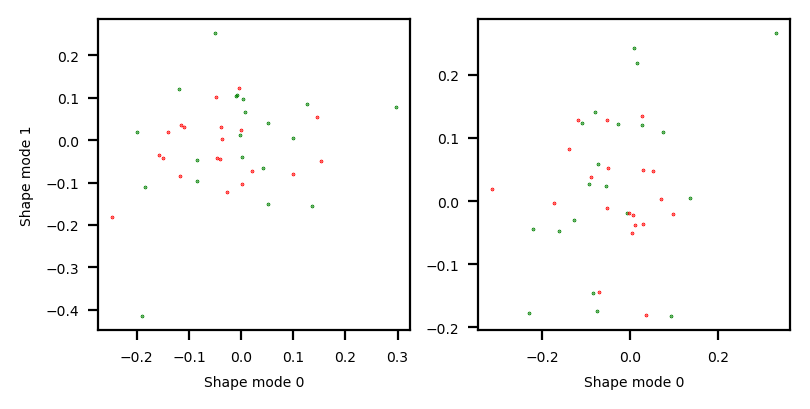

In [37]:
# take 10 highest/lowest error subjects, and 2d plot scatter of shape 0 vs 1
p_NMAE_best_indices = np.argsort(pressure_pred_evaluation['NMAE (%)'])[-10:]
p_NMAE_worst_indices = np.argsort(pressure_pred_evaluation['NMAE (%)'])[:10]
v_NMAE_best_indices = np.argsort(velocity_pred_evaluation['NMAE (%)'])[-10:]
v_NMAE_worst_indices = np.argsort(velocity_pred_evaluation['NMAE (%)'])[:10]
p_NMAE_best = pressure_pred_evaluation['NMAE (%)'][p_NMAE_best_indices]
p_NMAE_worst = pressure_pred_evaluation['NMAE (%)'][p_NMAE_worst_indices]
v_NMAE_best = velocity_pred_evaluation['NMAE (%)'][p_NMAE_best_indices]
v_NMAE_worst = velocity_pred_evaluation['NMAE (%)'][p_NMAE_worst_indices]

fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].scatter(X_test[p_NMAE_best_indices][0], X_test[p_NMAE_best_indices][1], s=0.1, c="g")
ax[0].scatter(X_test[p_NMAE_worst_indices][0], X_test[p_NMAE_worst_indices][1], s=0.1, c="r")
ax[0].set(xlabel="Shape mode 0", ylabel="Shape mode 1")
ax[1].scatter(X_test[v_NMAE_best_indices][0], X_test[v_NMAE_best_indices][1], s=0.1, c="g")
ax[1].scatter(X_test[v_NMAE_worst_indices][0], X_test[v_NMAE_worst_indices][1], s=0.1, c="r")
ax[1].set(xlabel="Shape mode 0")

fig.tight_layout()
plt.show()
#plt.savefig("/home/endrit/Documents/Deliverables/Papers/ML_COA/Figures/errors_boxplot.svg")

### Statistics

In [38]:
p_data_test_concat = np.ndarray.flatten(p_data_test)
p_pred_test_concat = np.ndarray.flatten(P_pred_inv_scaling)
v_data_test_concat = np.ndarray.flatten(v_data_test)
v_pred_test_concat = np.ndarray.flatten(V_pred_inv_scaling)

In [39]:
scipy.stats.ttest_rel(p_data_test_concat, p_pred_test_concat)
scipy.stats.ttest_rel(v_data_test_concat, v_pred_test_concat)

Ttest_relResult(statistic=-56.670511313444834, pvalue=0.0)

Read files with ascending, arch, descending nodes

In [40]:
points_ascending_csv = open("/home/endrit/Documents/Modelling/COA/pipeline_1650/Analysis/Mesh_Sections/points_ascending.csv", "r")
points_asc = pd.read_csv(points_ascending_csv, header=None, index_col=False)
points_asc = points_asc.to_numpy()

points_arch_csv = open("/home/endrit/Documents/Modelling/COA/pipeline_1650/Analysis/Mesh_Sections/points_arch.csv", "r")
points_arch = pd.read_csv(points_arch_csv, header=None, index_col=False)
points_arch = points_arch.to_numpy()

points_descending_csv = open("/home/endrit/Documents/Modelling/COA/pipeline_1650/Analysis/Mesh_Sections/points_descending.csv", "r")
points_desc = pd.read_csv(points_descending_csv, header=None, index_col=False)
points_desc = points_desc.to_numpy()

print(np.shape(points_asc))
print(np.shape(points_arch))
print(np.shape(points_desc))

(8360, 4)
(5873, 4)
(13190, 4)


In [41]:
pointids_asc = np.delete(points_asc[:,0], [0]).astype(int)
pointids_arch = np.delete(points_arch[:,0], [0]).astype(int)
pointids_desc = np.delete(points_desc[:,0], [0]).astype(int)
print(np.shape(pointids_asc))
print(np.shape(pointids_arch))
print(np.shape(pointids_desc))

(8359,)
(5872,)
(13189,)


**Extract pressure/velocity true/pred in all 3 regions**

In [42]:
# pressure
p_true_asc = p_data_test[:, pointids_asc]
p_true_arch = p_data_test[:, pointids_arch]
p_true_desc = p_data_test[:, pointids_desc]
p_pred_asc = P_pred_inv_scaling[:, pointids_asc]
p_pred_arch = P_pred_inv_scaling[:, pointids_arch]
p_pred_desc = P_pred_inv_scaling[:, pointids_desc]

# velocity
v_true_asc = v_data_test[:, pointids_asc]
v_true_arch = v_data_test[:, pointids_arch]
v_true_desc = v_data_test[:, pointids_desc]
v_pred_asc = V_pred_inv_scaling[:, pointids_asc]
v_pred_arch = V_pred_inv_scaling[:, pointids_arch]
v_pred_desc = V_pred_inv_scaling[:, pointids_desc]

Export Shooting 0 ascending, arch, descending just to check its working

In [43]:
shooting_0_empty_np = np.array(pred_empty_csv[0])
shooting_0_asc = shooting_0_empty_np[pointids_asc]
shooting_0_asc = np.column_stack((shooting_0_asc, p_true_asc[0]))
shooting_0_asc_csv = pd.DataFrame(shooting_0_asc)
shooting_0_asc_csv.rename(columns={0: 'x', 1: 'y', 2: 'z', 3: 'P_true'}, inplace=True)
#shooting_0_asc_csv.to_csv(data_dir + "shooting_0_asc.csv", index=False)

shooting_0_arch = shooting_0_empty_np[pointids_arch]
shooting_0_arch = np.column_stack((shooting_0_arch, p_true_arch[0]))
shooting_0_arch_csv = pd.DataFrame(shooting_0_arch)
shooting_0_arch_csv.rename(columns={0: 'x', 1: 'y', 2: 'z', 3: 'P_true'}, inplace=True)
#shooting_0_arch_csv.to_csv(data_dir + "shooting_0_arch.csv", index=False)

shooting_0_desc = shooting_0_empty_np[pointids_desc]
shooting_0_desc = np.column_stack((shooting_0_desc, p_true_desc[0]))
shooting_0_desc_csv = pd.DataFrame(shooting_0_desc)
shooting_0_desc_csv.rename(columns={0: 'x', 1: 'y', 2: 'z', 3: 'P_true'}, inplace=True)
#shooting_0_desc_csv.to_csv(data_dir + "shooting_0_desc.csv", index=False)

Compute average differences between each region (100 points)

In [46]:
# also equivalent to approach using MAE from sklearn (but dont need to average and therefore can get individual errors)

# NMAE: mean(abs(difference / ranges) * 100 )
test_ranges = np.ptp(p_data_test, axis=1)
test_diffs_1 = np.mean(abs(p_data_test - P_pred_inv_scaling)*100/test_ranges.reshape(len(test_ranges), 1))
print(np.mean(test_diffs_1))

4.327872283835366


In [586]:
'''
def bland_altman_plot(data1, data2, ranges, axis0, axis1, c, title, xlabel, ylabel, *args, **kwargs):
    
    mean      = np.mean([np.mean(data1, axis=1), np.mean(data2, axis=1)], axis=0)
    #diff      = np.mean((data1 - data2)*100 / ranges.reshape(len(ranges), 1), axis=1)  # Difference between data1 and data2
    # print NMAE of region
    print(np.mean(np.mean(abs(data1 - data2)*100/ranges.reshape(len(ranges), 1))))
    diff      = np.mean(data1, axis=1) - np.mean(data2, axis=1)
    md        = np.mean(diff)                                                          # Mean of the difference
    sd        = np.std(diff, axis=0)                                                   # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    ax[axis0][axis1].scatter(mean, diff, c=c, s=0.3, *args, **kwargs)
    ax[axis0][axis1].axhline(md,           color='gray', linewidth=0.5)
    ax[axis0][axis1].axhline(md + 1.96*sd, color='gray', linestyle='--', linewidth=0.5)
    ax[axis0][axis1].axhline(md - 1.96*sd, color='gray', linestyle='--', linewidth=0.5)
    ax[axis0][axis1].set(xlabel="Means", ylabel="Differences")
    
    ax[axis0][axis1].set(title=title)
    ax[axis0][axis1].set_xlabel("Means")
    ax[axis0][axis1].set_ylabel(ylabel)
    ax[axis0][axis1].set_ylim(md - 3.5*sd, md + 3.5*sd)
    
    xOutPlot = np.min(mean) + (np.max(mean)-np.min(mean))*1.04
    
    ax[axis0][axis1].text(xOutPlot, md - 1.96*sd, 
                          
        r'-1.96SD:' + "\n" + "%.2f" % CI_low, 
        ha = "right",
        va = "center",
        )
    ax[axis0][axis1].text(xOutPlot, md + 1.96*sd, 
        r'+1.96SD:' + "\n" + "%.2f" % CI_high, 
        ha = "right",
        va = "center",
        )
    ax[axis0][axis1].text(xOutPlot, md, 
        r'Mean:' + "\n" + "%.2f" % md, 
        ha = "right",
        va = "center",
        )
'''

In [69]:
def bland_altman_concat(data1, data2, ranges, axis0, axis1, xmin, xmax, ymin, ymax, c, title, xlabel, ylabel, *args, **kwargs):
    '''
    concats all subjects - 100 * 27420 = 2742000 then computes a BA 
    normalises by the ranges with respect to subject
    samples random 1000 nodes from means and differences and plots them
    '''
    ranges = np.repeat(ranges, data1[0].shape[0])
    #ranges = np.repeat(ranges, data1[0].shape[0])
    data1 = data1.flatten()
    data2 = data2.flatten()
    
    mean      = np.mean([data1, data2], axis=0)
    diff      = (data1 - data2)*100 / ranges # Difference between data1 and data2
    # print NMAE of region
    #print(np.mean(abs(data1 - data2) * 100/ranges))
    md        = np.mean(diff)                                                          # Mean of the difference
    sd        = np.std(diff, axis=0)                                                   # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd
    print(sd)
    
    x_sub, y_sub = zip(*random.sample(list(zip(mean, diff)), 1000))
    
    ax[axis0][axis1].scatter(x_sub, y_sub, c=c, s=0.2, *args, **kwargs)
    ax[axis0][axis1].axhline(md,           color='gray', linewidth=0.5)
    ax[axis0][axis1].axhline(md + 1.96*sd, color='gray', linestyle='--', linewidth=0.5)
    ax[axis0][axis1].axhline(md - 1.96*sd, color='gray', linestyle='--', linewidth=0.5)
    ax[axis0][axis1].set(xlabel="Means", ylabel="Differences")
    
    ax[axis0][axis1].set(title=title)
    ax[axis0][axis1].set_xlabel(xlabel)
    ax[axis0][axis1].set_ylabel(ylabel)
    #ax[axis0][axis1].set_ylim(md - 3.5*sd, md + 3.5*sd)
    ax[axis0][axis1].set_xlim(xmin, xmax)
    ax[axis0][axis1].set_ylim(ymin, ymax)
    
    #xOutPlot = np.min(x_sub) + (np.max(x_sub)-np.min(x_sub))*1.04
    xOutPlot = xmin + (xmax-xmin)*0.995
    
    txt1 = ax[axis0][axis1].text(xOutPlot, md - 1.96*sd,                           
        r'-1.96SD:' + "\n" + "%.2f" % CI_low, 
        ha = "right",
        va = "center",
        #linespacing = 1.5,
        #fontweight="bold"
        )
    txt2 = ax[axis0][axis1].text(xOutPlot, md + 1.96*sd, 
        r'+1.96SD:' + "\n" + "%.2f" % CI_high, 
        ha = "right",
        va = "center",
        #linespacing = 1.5,
        #fontweight="bold"
        )
    txt3 = ax[axis0][axis1].text(xOutPlot, md, 
        r'Mean:' + "\n" + "%.2f" % md, 
        ha = "right",
        va = "center",
        #linespacing = 1.5,
        #fontweight="bold"
        )
    #txt1.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    #txt2.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])
    #txt3.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

5.956959692077274
6.668833424815744
6.2733628186366746
5.279088939080228
7.393647315544932
5.161443786747498
7.410106187588039
8.499578920681135


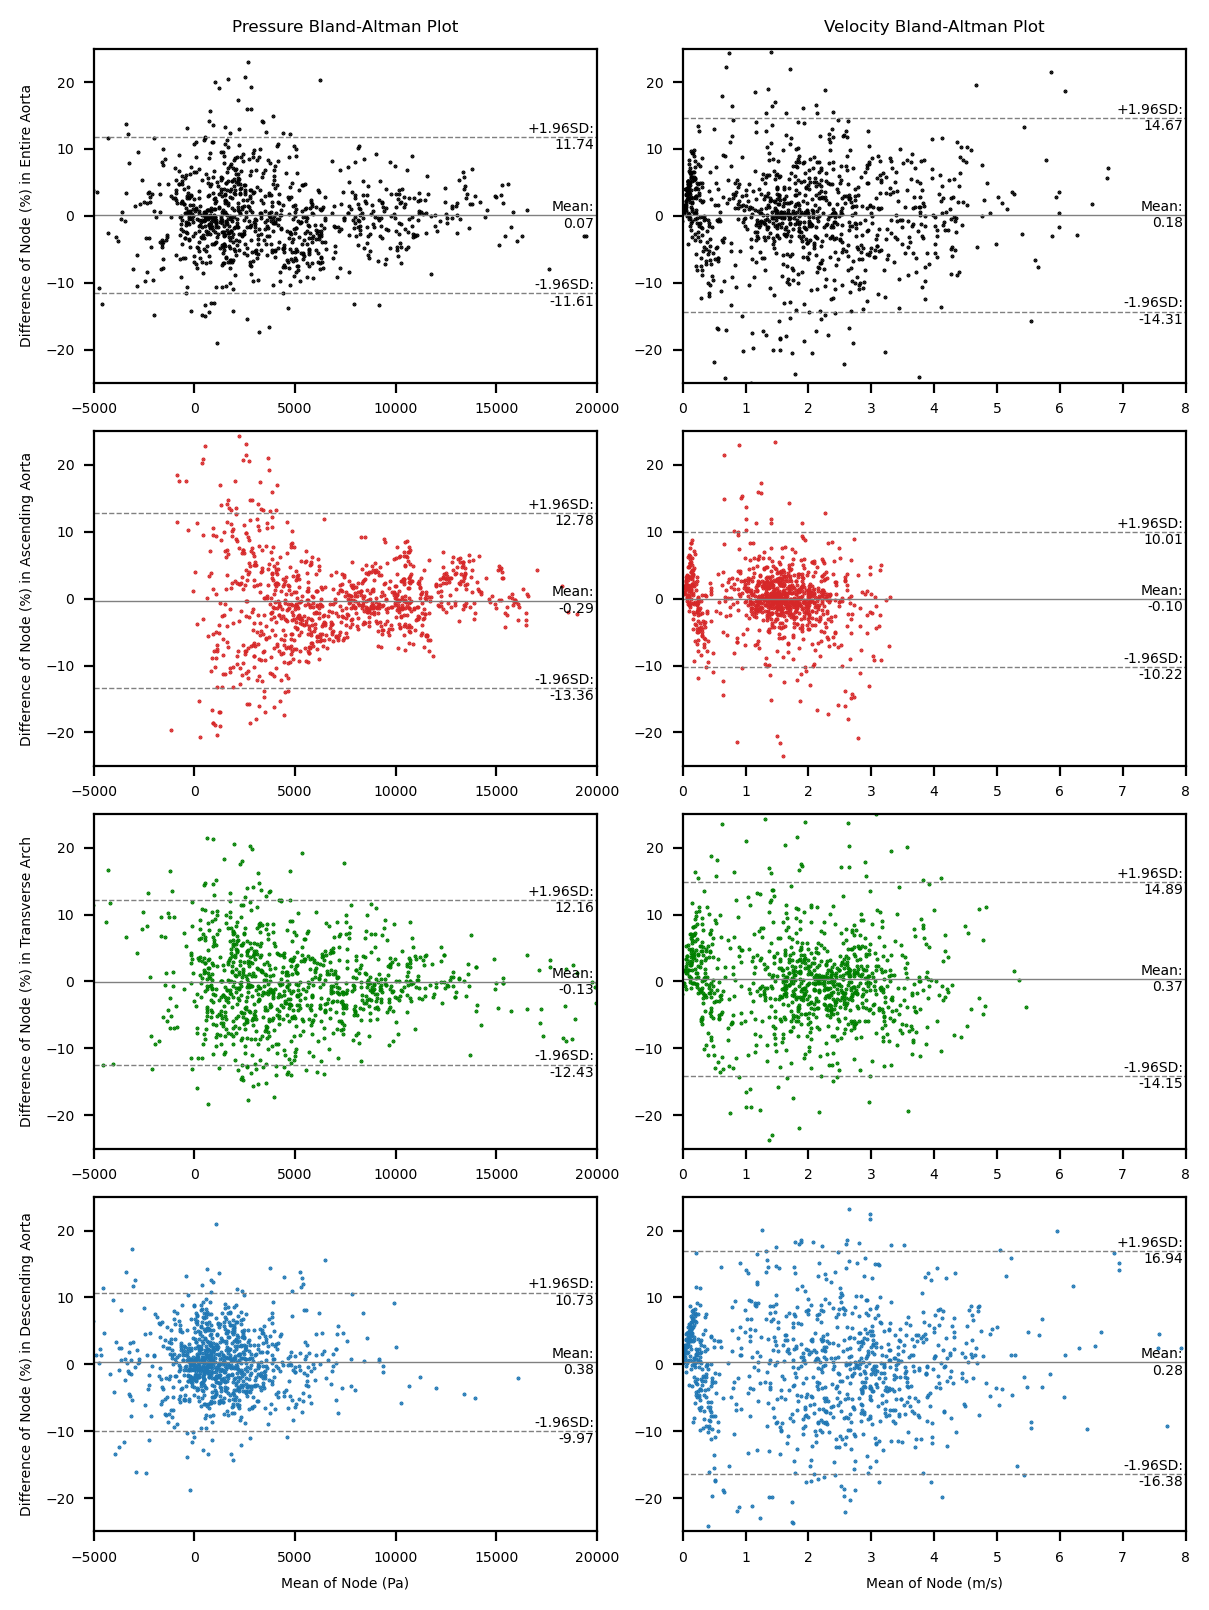

In [70]:
f, ax = plt.subplots(4, 2, figsize = (6, 8))

# compute range of pressure/velocity values per subject
# use OVERALL ao range for each region (prevents ascending Ao errors being massively blown up for example)
ranges_p = np.ptp(p_data_test, axis=1)
ranges_v = np.ptp(v_data_test, axis=1)

# pressure
bland_altman_concat(P_pred_inv_scaling, p_data_test, ranges_p, 0, 0, -5000, 20000, -25, 25,
                    "k", "Pressure Bland-Altman Plot", "", "Difference of Node (%) in Entire Aorta")
bland_altman_concat(p_pred_asc, p_true_asc, ranges_p, 1, 0, -5000, 20000, -25, 25,
                    "tab:red", "", "", "Difference of Node (%) in Ascending Aorta") 
bland_altman_concat(p_pred_arch, p_true_arch, ranges_p, 2, 0, -5000, 20000, -25, 25,
                    "green", "",  "", "Difference of Node (%) in Transverse Arch")
bland_altman_concat(p_pred_desc, p_true_desc, ranges_p, 3, 0, -5000, 20000, -25, 25,
                    "tab:blue", "", "Mean of Node (Pa)", "Difference of Node (%) in Descending Aorta")
# velocity
bland_altman_concat(V_pred_inv_scaling, v_data_test, ranges_v, 0, 1, 0, 8, -25, 25,
                    "k", "Velocity Bland-Altman Plot", "", "")
bland_altman_concat(v_pred_asc, v_true_asc, ranges_v, 1, 1, 0, 8, -25, 25,
                    "tab:red", "", "", "")
bland_altman_concat(v_pred_arch, v_true_arch, ranges_v, 2, 1, 0, 8, -25, 25,
                    "green", "", "", "")
bland_altman_concat(v_pred_desc, v_true_desc, ranges_v, 3, 1, 0, 8, -25, 25,
                    "tab:blue", "", "Mean of Node (m/s)", "")

plt.tight_layout()
#plt.savefig("/home/endrit/Documents/Deliverables/Papers/ML_COA/Figures/bland_altman_%.svg")
plt.show()

### Saving Predictions

**Save csv file of metrics**

In [164]:
pressure_pred_evaluation.to_csv(data_dir+"evaluation_pressure.csv", sep='\t')
velocity_pred_evaluation.to_csv(data_dir+"evaluation_velocity.csv", sep='\t')

**Save predicted point clouds as csv**

In [165]:
for i in range(len(pred_csv)):
    pred_full_csv = pd.DataFrame(pred_csv[i])
    pred_full_csv.rename(columns={0: 'x', 1: 'y', 2: 'z', 3: 'Pressure_pred_(Pa)', 4: 'Velocity_pred_(m/s)', 
                            5: 'Pressure_error_(Pa)', 6: 'Velocity_error_(m/s)'}, inplace=True)
    pred_full_csv.to_csv(data_dir + "pred_" + str(fnames[i+train_n]) + ".csv", index=False)